## The goals / steps of this project are the following:

1) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

2) Apply a distortion correction to raw images.

3) Use color transforms, gradients, etc., to create a thresholded binary image.

4) Apply a perspective transform to rectify binary image ("birds-eye view").

5) Detect lane pixels and fit to find the lane boundary.

6) Determine the curvature of the lane and vehicle position with respect to center.

7) Warp the detected lane boundaries back onto the original image.

8) Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Strategy: 
    - Generate and save transformation matrices to undistort images
    - Create undistort function

# 1) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.

## Saves the relevant transformation matrices in a pickle file for saving time in the next set of codes

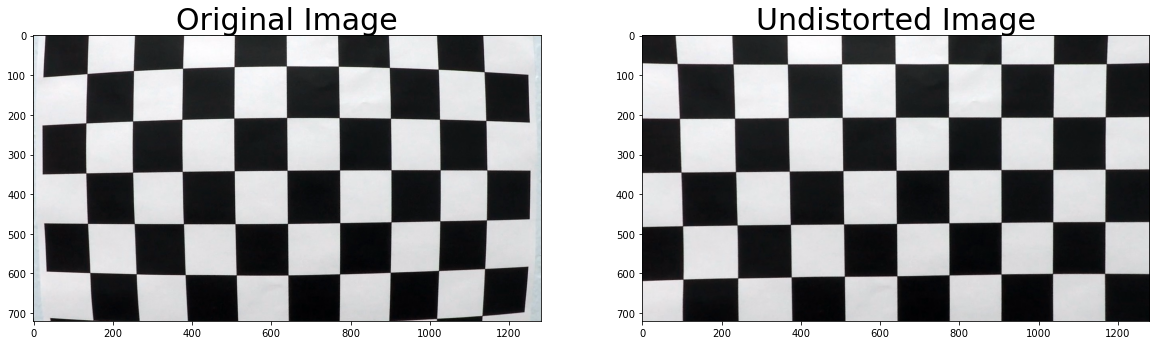

In [11]:

import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
#%matplotlib notebook

# Finding image and object points

def undistort(test_img):
# prepare object points (our ideal reference), like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# Stores mtx and dist coefficients in a pickle file to use later
    nx=9    # Number of inner corners of our chessboard along x axis (or columns)
    ny=6    # Number of inner corners of our chessboard along y axis (or rows)

    objp = np.zeros((ny*nx,3), np.float32)                  #We have 9 corners on X axis and 6 corners on Y axis
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)       # Gives us coorinate points in pairs as a list of 54 items. It's shape will be (54,2)       

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space. These are the points for our ideal chessboard which we are using as a reference.       
    imgpoints = [] # 2d points in image plane. We'll extract these from the images given for caliberating the camera

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        calib_img = cv2.imread(fname)
        gray = cv2.cvtColor(calib_img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        # Grayscale conversion ensures an 8bit image as input.The next function needs that kind of input only. Generally color images are 24 bit images. (Refer "Bits in images" in notes) 
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)      # These will be same for caliberation image. The same points will get appended every time this fires up 
            imgpoints.append(corners)   # Corners 
            
            # Draw and display the corners                                  #This step can be completely skipped
            cv2.drawChessboardCorners(calib_img, (nx,ny), corners, ret)
            write_name = 'corners_found'+str(idx)+'.jpg'
            cv2.imwrite('output_files/corners_found_for_calib/'+write_name, calib_img)  
            cv2.imshow(write_name, calib_img)  #We dont want to see the images now so commenting out. TO see output later, un-comment these 3 lines
            cv2.waitKey(500)   #Delete after testing. These will be used to show you images one after the other

    cv2.destroyAllWindows()   #Delete this after testing
    
    # Test undistortion on an image

    test_img_size = (test_img.shape[1], test_img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_img_size,None,None)
    
    # Use the above obtained results to undistort 
    undist_img = cv2.undistort(test_img, mtx, dist, None, mtx)
    
    cv2.imwrite('output_files/test_undist.jpg',undist_img)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "output_files/calib_pickle_files/dist_pickle.p", "wb" ) )
    #undist_img = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

    return undist_img
    
    

test_img= cv2.imread('camera_cal/calibration1.jpg')    #Note: Your image will be in BGR format
"my_test_images/Highway_snaps/image (1).jpg"
output=undistort(test_img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))        #Refer subplots in python libraries
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(output)
ax2.set_title('Undistorted Image', fontsize=30)
cv2.waitKey(500)
cv2.destroyAllWindows()


# 2) Apply a distortion correction to raw images

Now we'll use the transformation matrices stored in the pickle file above and try undistorting example images

Precaution: If you're reading colored image with cv2, convert it to RGB from BGR before using ax.imshow(). 

Reason: It requred a RGB image if it is 3D

So I'm leaving a comment in my *"cal_undistort function"* to do the conversion in case you use cv2 to read frames and plan to output using ax.imshow()

(720, 1280, 3)
To note the changes, look carefully at the outer boundary of both the images


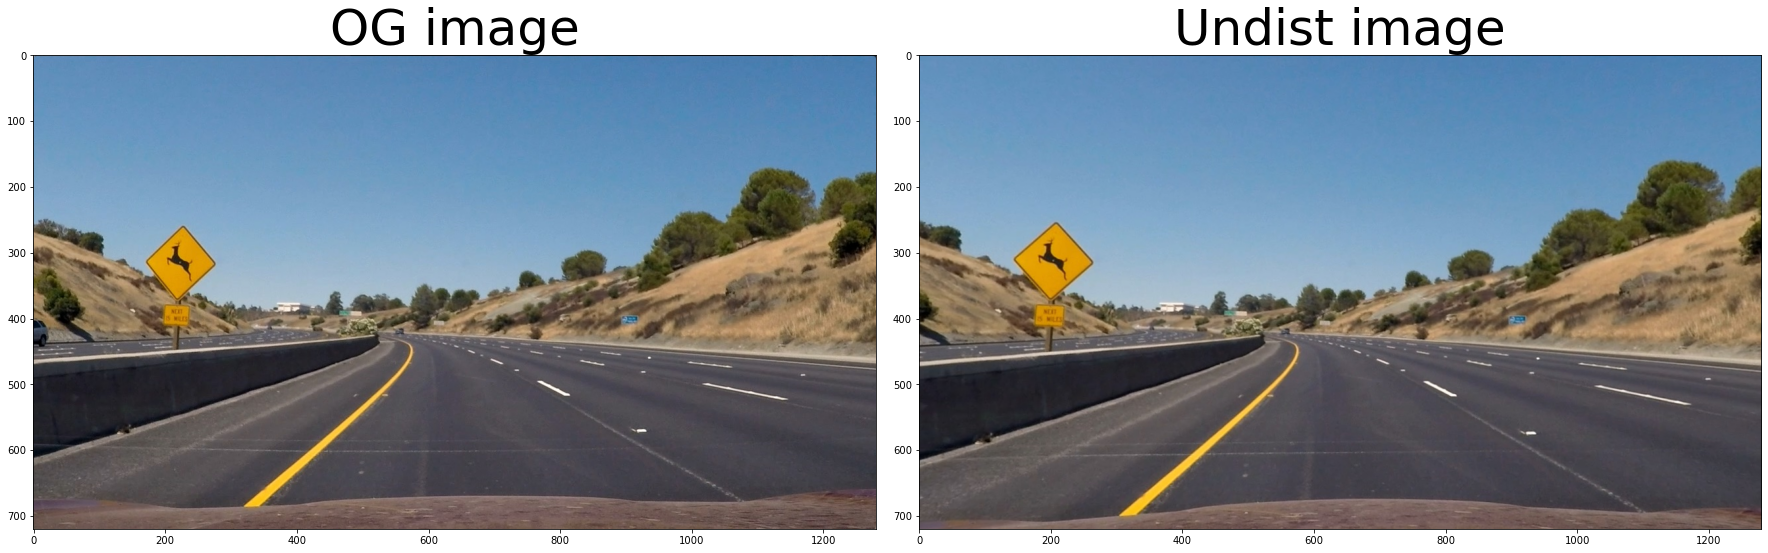

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def cal_undistort(img):
# Reads mtx and dist matrices, peforms image distortion correction and returns the undistorted image

    import pickle
        
    # Read in the saved matrices
    my_dist_pickle = pickle.load( open( "output_files/calib_pickle_files/dist_pickle.p", "rb" ) )
    mtx = my_dist_pickle["mtx"]
    dist = my_dist_pickle["dist"]

    img_size = (img.shape[1], img.shape[0])    

    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    #undistorted_img =  cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)   #Use if you use cv2 to import image. ax.imshow() needs RGB image
    return undistorted_img

def draw_subplot(img1,name1,img2,name2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)  #Needs an RGB image for 3D images. For 2D images, it auto-colors them so use cmap='gray' to get grayscale if needed
    ax1.set_title(name1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(name2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Read in an image
img = mpimg.imread('test_images/test2.jpg')           # highway image

#img = mpimg.imread('camera_cal/calibration3.jpg')    # chessboard image

undistorted = cal_undistort(img)

draw_subplot(img,"OG image",undistorted,"Undist image")

print("To note the changes, look carefully at the outer boundary of both the images")

# 3) Use color transforms, gradients, etc., to create a thresholded binary image.


Caution: In the thresh_img() function, we begin by coverting our color space from RGB to HLS. We need to check whether our image was RGB or BGR when it was extracted from the frame?

Note: Put undistorted RGB images in this function

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def thresh_img(img):
    """
    x gradient will identify lanes far away from us 
    Saturation channel will help us with the lanes near us. This will help if there's a lot of light
    """    
    
    """Starting with color channel"""
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    
    h_thresh_min = 21
    h_thresh_max = 22
        
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1

    
    """Now handling the x gradient"""
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (h_binary == 1)) | (sxbinary == 1)] = 1
    #Used h as well so as to reduce noise in the image
    
    out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
    
    #return combined_binary
    return out_img


# 4) Apply a perspective transform to rectify binary image ("birds-eye view")

In [4]:
def perspective_transform(img):
    
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    
    img_size = (img.shape[1], img.shape[0])
    """Notice the format used for img_size. Yaha bhi ulta hai. x axis aur fir y axis chahiye. 
          Apne format mein rows(y axis) and columns (x axis) hain"""
    
    
    # Four source coordinates

    src = np.array(
        [[437*img.shape[1]/960, 331*img.shape[0]/540],
         [523*img.shape[1]/960, 331*img.shape[0]/540],
         [850*img.shape[1]/960, img.shape[0]],
         [145*img.shape[1]/960, img.shape[0]]], dtype='f')
    
    
    # Next, we'll define a desired rectangle plane for the warped image.
    # We'll choose 4 points where we want source points to end up 
    # This time we'll choose our points by eyeballing a rectangle
    
    dst = np.array(
        [[290*img.shape[1]/960, 0],
         [740*img.shape[1]/960, 0],
         [740*img.shape[1]/960, img.shape[0]],
         [290*img.shape[1]/960, img.shape[0]]], dtype='f')
    
    
    #Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
  
    #Warp an image using the perspective transform, M; using linear interpolation    
    #Interpolating points is just filling in missing points as it warps an image
    # The input image for this function can be a colored image too
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped,src,dst


# Master Pipeline

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image(frame):
    
    def cal_undistort(img):
        # Reads mtx and dist matrices, peforms image distortion correction and returns the undistorted image

        import pickle

        # Read in the saved matrices
        my_dist_pickle = pickle.load( open( "output_files/calib_pickle_files/dist_pickle.p", "rb" ) )
        mtx = my_dist_pickle["mtx"]
        dist = my_dist_pickle["dist"]

        img_size = (img.shape[1], img.shape[0])    

        undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
        #undistorted_img =  cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)   #Use if you use cv2 to import image. ax.imshow() needs RGB image
        return undistorted_img

    
    def yellow_threshold(img, sxbinary):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        h_channel = hls[:,:,0]
        # Threshold color channel
        s_thresh_min = 100
        s_thresh_max = 255
        
        #for 360 degree, my value for yellow ranged between 35 and 50. So uska half kar diya
        h_thresh_min = 10    
        h_thresh_max = 25

        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1

        # Combine the two binary thresholds
        yellow_binary = np.zeros_like(s_binary)
        yellow_binary[(((s_binary == 1) | (sxbinary == 1) ) & (h_binary ==1))] = 1
        return yellow_binary
    
    def xgrad_binary(img, thresh_min=30, thresh_max=100):
        # Grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        # Threshold x gradient
        #thresh_min = 30    #Already given above
        #thresh_max = 100

        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return sxbinary
    
    def white_threshold(img, sxbinary, lower_white_thresh = 170):
        r_channel = img[:,:,0]
        g_channel = img[:,:,1]
        b_channel = img[:,:,2]
        # Threshold color channel
        r_thresh_min = lower_white_thresh
        r_thresh_max = 255
        r_binary = np.zeros_like(r_channel)
        r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
        
        g_thresh_min = lower_white_thresh
        g_thresh_max = 255
        g_binary = np.zeros_like(g_channel)
        g_binary[(g_channel >= g_thresh_min) & (g_channel <= g_thresh_max)] = 1

        b_thresh_min = lower_white_thresh
        b_thresh_max = 255
        b_binary = np.zeros_like(b_channel)
        b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

        white_binary = np.zeros_like(r_channel)
        white_binary[((r_binary ==1) & (g_binary ==1) & (b_binary ==1) & (sxbinary==1))] = 1
        return white_binary
        
    def thresh_img(img):
                       
       
        #sxbinary = xgrad_binary(img, thresh_min=30, thresh_max=100)
        sxbinary = xgrad_binary(img, thresh_min=25, thresh_max=130)
        yellow_binary = yellow_threshold(img, sxbinary)     #(((s) | (sx)) & (h))
        white_binary = white_threshold(img, sxbinary, lower_white_thresh = 150)
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[((yellow_binary == 1) | (white_binary == 1))] = 1
        
        out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
        
        return out_img
    
    def perspective_transform(img):
    
        # Define calibration box in source (original) and destination (desired or warped) coordinates

        img_size = (img.shape[1], img.shape[0])
        """Notice the format used for img_size. Yaha bhi ulta hai. x axis aur fir y axis chahiye. 
              Apne format mein rows(y axis) and columns (x axis) hain"""


        # Four source coordinates
        # Order of points: top left, top right, bottom right, bottom left
        
        src = np.array(
            [[435*img.shape[1]/960, 350*img.shape[0]/540],
             [530*img.shape[1]/960, 350*img.shape[0]/540],
             [885*img.shape[1]/960, img.shape[0]],
             [220*img.shape[1]/960, img.shape[0]]], dtype='f')
        

        # Next, we'll define a desired rectangle plane for the warped image.
        # We'll choose 4 points where we want source points to end up 
        # This time we'll choose our points by eyeballing a rectangle

        dst = np.array(
            [[290*img.shape[1]/960, 0],
             [740*img.shape[1]/960, 0],
             [740*img.shape[1]/960, img.shape[0]],
             [290*img.shape[1]/960, img.shape[0]]], dtype='f')


        #Compute the perspective transform, M, given source and destination points:
        M = cv2.getPerspectiveTransform(src, dst)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
              
        return warped, src, dst 
    
    def draw_polygon(img1, img2, src, dst):
        src = src.astype(int)  #Very important step (Pixels cannot be in decimals)
        dst = dst.astype(int)
        cv2.polylines(img1, [src], True, (255,0,0), 3)
        cv2.polylines(img2, [dst], True, (255,0,0), 3)
    
    def histogram_bottom_peaks (warped_img):
        # This will detect the bottom point of our lane lines
        
        # Take a histogram of the bottom half of the image
        bottom_half = warped_img[((2*warped_img.shape[0])//5):,:,0]     # Collecting all pixels in the bottom half
        histogram = np.sum(bottom_half, axis=0)                         # Summing them along y axis (or along columns)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)        # 1D array hai histogram toh uska bas 0th index filled hoga 
        #print(np.shape(histogram))     #OUTPUT:(1280,)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        return leftx_base, rightx_base
    
    def find_lane_pixels(warped_img):
    
        leftx_base, rightx_base = histogram_bottom_peaks(warped_img)
   
        # Create an output image to draw on and visualize the result
        out_img = np.copy(warped_img)
        
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin. So width = 2*margin 
        margin = 90
        # Set minimum number of pixels found to recenter window
        minpix = 1000    #I've changed this from 50 as given in lectures
    
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(warped_img.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped_img.nonzero()  #pixel ke coordinates dega 2 seperate arrays mein
        nonzeroy = np.array(nonzero[0])    # Y coordinates milenge 1D array mein. They will we arranged in the order of pixels
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base         #initially set kar diya hai. For loop ke end mein change karenge
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []   # Ismein lane-pixels ke indices collect karenge. 
                              # 'nonzerox' array mein index daalke coordinate mil jaayega
        right_lane_inds = []  

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_img.shape[0] - (window+1)*window_height
            win_y_high = warped_img.shape[0] - window*window_height
            """### TO-DO: Find the four below boundaries of the window ###"""
            win_xleft_low = leftx_current - margin  
            win_xleft_high = leftx_current + margin  
            win_xright_low = rightx_current - margin  
            win_xright_high = rightx_current + margin 

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
            

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            #Iska poora explanation seperate page mein likha hai
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]


            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on the mean position of the pixels in your current window (re-centre)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img
        

    def fit_polynomial(warped_img):
    
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_img)

        ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)

        # Generate x and y values for plotting. 
        #NOTE: y is the independent variable. Refer "fit polynomial" notes for explanation
        # We'll plot x as a function of y
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        
        # Eqn of parabola: a(x**2) + bx + c. Where a and b denote the shape of parabola. Shape of parabola will be amost constant inn our case 
        """
        a = (0.85*left_fit[0] + 0.15*right_fit[0])
        b = (0.85*left_fit[1] + 0.15*right_fit[1])
        
        try:
            left_fitx = a*ploty**2 + b*ploty + left_fit[2]
            c1 = left_fit[2]    
            c2 = (warped_img.shape[1] - (a*(warped_img.shape[0]-1)**2 + b*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]
            
            right_fitx = a*ploty**2 + b*ploty + c2
        """
        
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            
            a2 = (0.6*left_fit[0] + 0.4*right_fit[0])
            b2 = (0.6*left_fit[1] + 0.4*right_fit[1])
            c2 = (warped_img.shape[1] - (left_fit[0]*(warped_img.shape[0]-1)**2 + left_fit[1]*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]
            
            right_fitx = a2*ploty**2 + b2*ploty + c2
        
        
        #try:
        #    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

        return out_img

    
    undist_img = cal_undistort(frame)
    thresh_img = thresh_img(undist_img)    # Note: This is not a binary iamge. It has been stacked already within the function
    warped_img, src, dst = perspective_transform(thresh_img)
    #draw_polygon(frame, warped_img, src, dst)   #the first image is the original image that you import into the system
    lane_identified = fit_polynomial(warped_img)
    
    #return thresh_img, warped_img    #3 images dekhne ke liye ye return
    #return warped_img, lane_identified          
    return lane_identified
    


# 5) Detect lane pixels and fit to find the lane boundary.

In [6]:
#image= mpimg.imread("my_test_images/Highway_snaps/image (1).jpg")
#image= mpimg.imread("my_test_images/Highway_snaps/image (2).jpg")
image= mpimg.imread("my_test_images/Highway_snaps/image (3).jpg")

#image = mpimg.imread("my_test_images/starter.JPG")
#image = mpimg.imread("my_test_images/straight_road.JPG")                         
#image = mpimg.imread("my_test_images/change_road_color.JPG")                  # right lane too straight
#image = mpimg.imread("my_test_images/leaving_tree_to_road_color_change.JPG")
#image = mpimg.imread("my_test_images/tree_and_color_change.JPG")
#image = mpimg.imread("my_test_images/trees_left_lane_missing.JPG")               # little curvature in right lane
#image = mpimg.imread("my_test_images/trees_left_lane_missing2.JPG")          #right lane ka curvature aa raha hai though road is straighimage = mpimg.imread("my_test_images/1.JPG")
#image = mpimg.imread("my_test_images/2.JPG")                     #too less data points in right lane
#image = mpimg.imread("my_test_images/3.JPG")             ####Toobad###    #bad frame maybe: too less points in right lane. curve kuch bhi bana
#image = mpimg.imread("my_test_images/4.JPG")

#image = mpimg.imread("my_test_images/finding_hue.JPG")
#image = mpimg.imread("my_test_images/finding_hue2.JPG")         #ismein yellow bohot kam ho gaya ab


lane_identified=process_image(image)
plt.imshow(lane_identified)
"""
def draw_subplot(img1,name1,img2,name2, img3,name3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    
    ax1.imshow(img1)  #Needs an RGB image for 3D images. For 2D images, it auto-colors them so use cmap='gray' to get grayscale if needed
    ax1.set_title(name1, fontsize=50)
    ax2.imshow(img2)  #Needs an RGB image for 3D images. For 2D images, it auto-colors them so use cmap='gray' to get grayscale if needed
    ax2.set_title(name2, fontsize=50)
    ax3.imshow(img3)
    ax3.set_title(name3, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
#draw_subplot(image,"OG",output,"lala lala image")
draw_subplot(image, "OG image",thresh_img,"Thresh_img",warped_img,"Bird eye's view")
"""

LinAlgError: SVD did not converge in Linear Least Squares

Remember to atleast stack binary images to form color images. 

## Reset
If your sanity checks reveal that the lane lines you've detected are problematic for some reason, you can simply assume it was a bad or difficult frame of video, retain the previous positions from the frame prior and step to the next frame to search again. If you lose the lines for several frames in a row, you should probably start searching from scratch using a histogram and sliding window, or another method, to re-establish your measurement.

## Smoothing
Even when everything is working, your line detections will jump around from frame to frame a bit and it can be preferable to smooth over the last n frames of video to obtain a cleaner result. Each time you get a new high-confidence measurement, you can append it to the list of recent measurements and then take an average over n past measurements to obtain the lane position you want to draw onto the image.

# Project video

t:   0%|          | 0/175 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_files/video_clips/project_video.mp4.
Moviepy - Writing video output_files/video_clips/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_files/video_clips/project_video.mp4
Wall time: 42.5 s


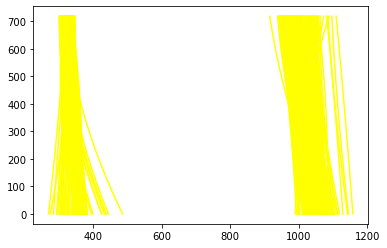

In [2]:
project_output = 'output_files/video_clips/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("project_video.mp4").subclip(18,25)

project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images! 
%time project_clip.write_videofile(project_output, audio=False)

In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
# challenge video

In [ ]:
challenge_output = 'output_files/video_clips/challenge_video_old.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

clip2 = VideoFileClip("challenge_video.mp4")
#clip2 = VideoFileClip("challenge_video.mp4").subclip(0,1)

challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images! 
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))